In [11]:
from rembg import remove 
from PIL import Image 
import io
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from torchvision import transforms
import torchvision.transforms.functional as TF
import shutil

In [2]:


# Load the images
ball_paths = os.listdir("isolated_balls")
all_hoop_paths = os.listdir("cls_training_data_by_vid/0")
# remove the .DS_Store file from the list
if '.DS_Store' in ball_paths:
    ball_paths.remove('.DS_Store')
if '.DS_Store' in all_hoop_paths:
    all_hoop_paths.remove('.DS_Store')
    
hoop_paths = []
# select hoop images only if the image's ratio is around 1:1
for hoop_path in all_hoop_paths:
    hoop_image = Image.open("cls_training_data_by_vid/0/" + hoop_path).convert("RGBA")
    if hoop_image.width / hoop_image.height > 0.8 and hoop_image.width / hoop_image.height < 1.2:
        hoop_paths.append(hoop_path)
print(len(hoop_paths))

1026


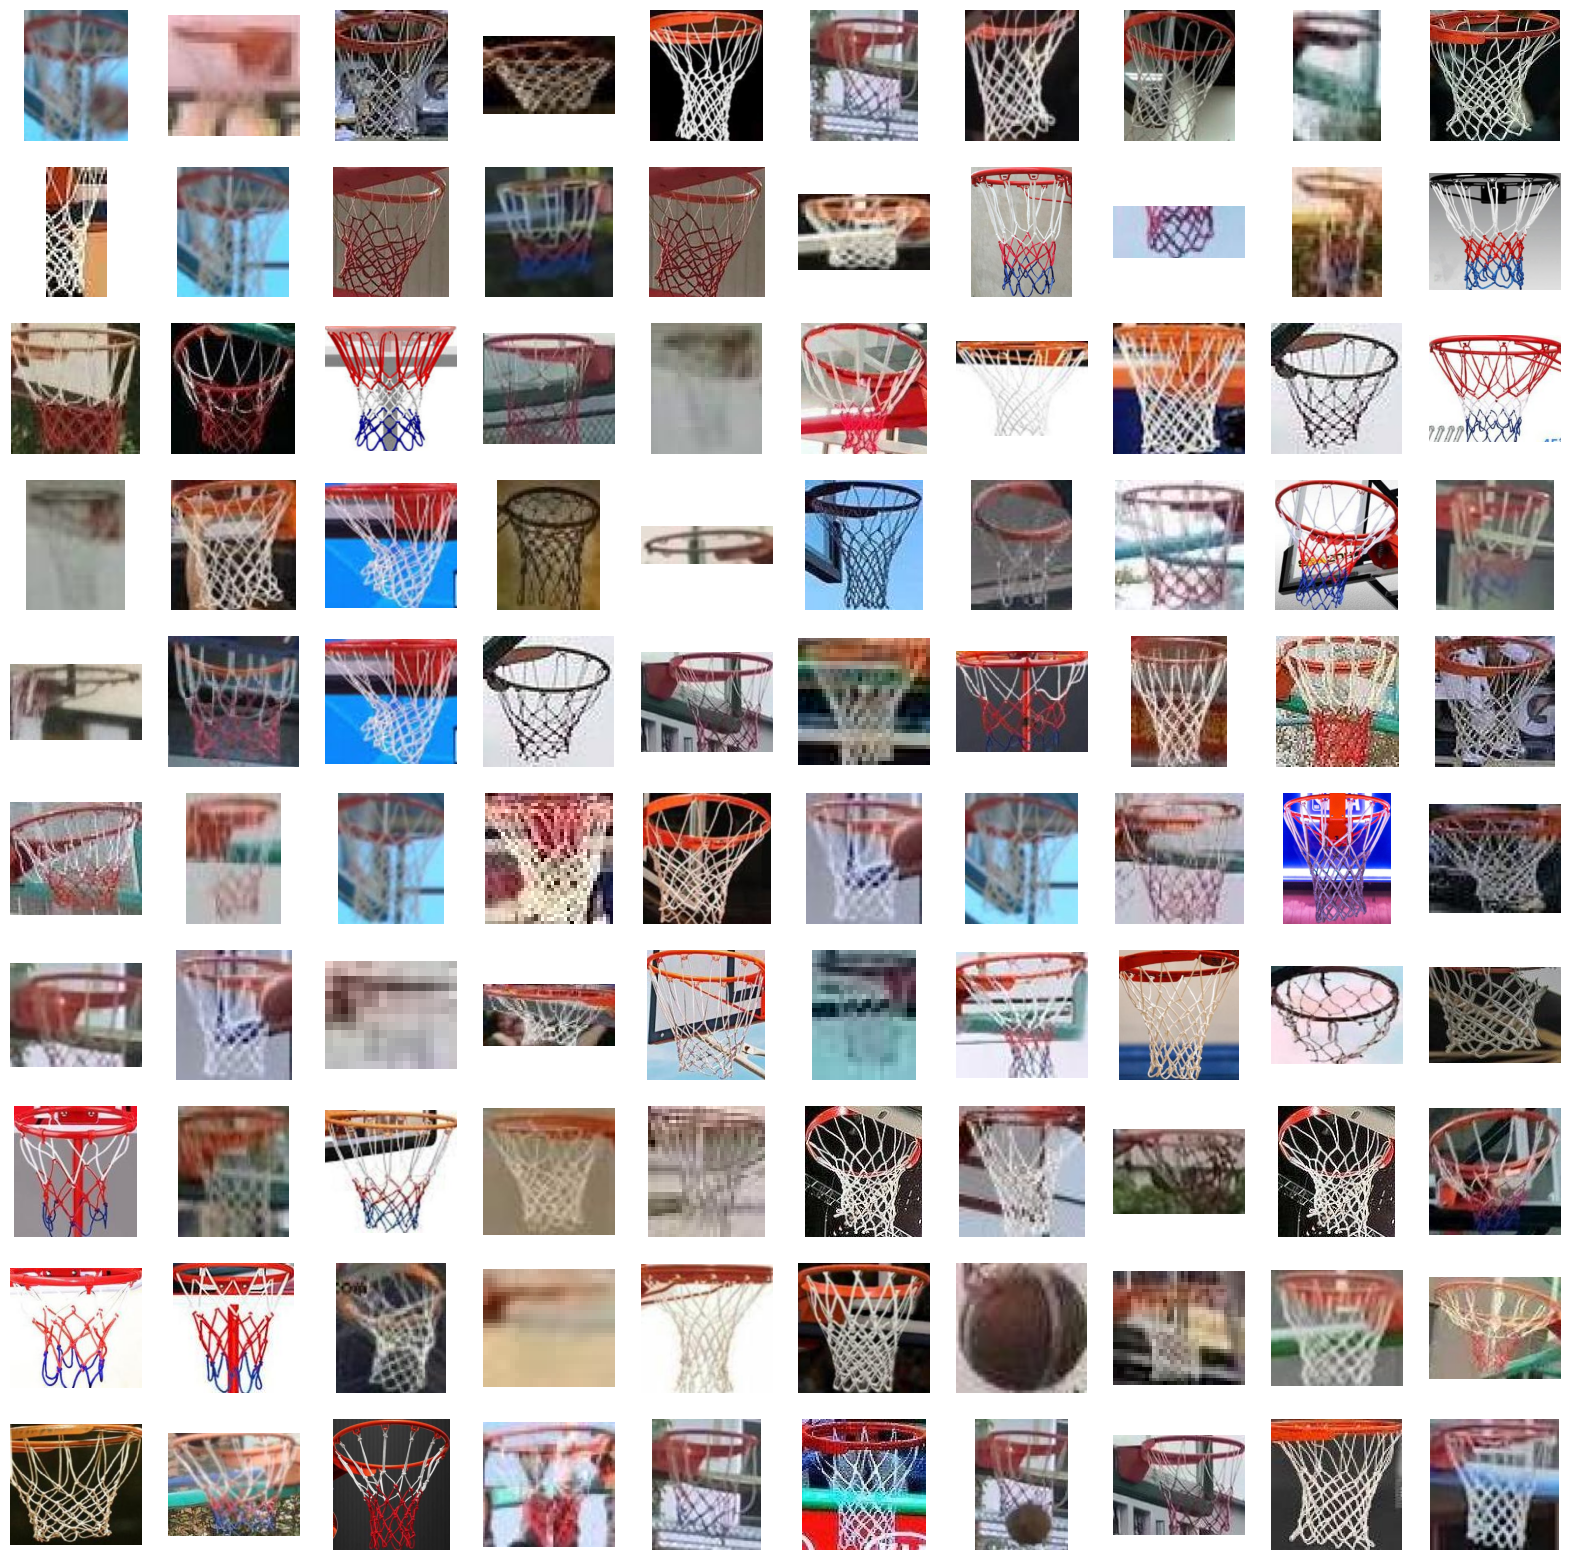

In [5]:
# randomly select 100 hoop images and use matplotlib to display them 10x10
hoop_paths = np.random.choice(all_hoop_paths, 100)
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
ax = ax.flatten()
for i in range(len(hoop_paths)):
    hoop_image = Image.open("cls_training_data_by_vid/0/" + hoop_paths[i]).convert("RGBA")
    ax[i].imshow(hoop_image)
    ax[i].axis('off')

In [8]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, hue=.05, saturation=0.2, contrast=0.2),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms.ToTensor()
])

save_dir = 'synthetic_images'
os.makedirs(save_dir, exist_ok=True)

num_synthetic_images = round(len(hoop_paths) * 0.7)

random_hoops = np.random.choice(hoop_paths, num_synthetic_images)
random_ratios = np.random.uniform(0.5, 0.83, num_synthetic_images)

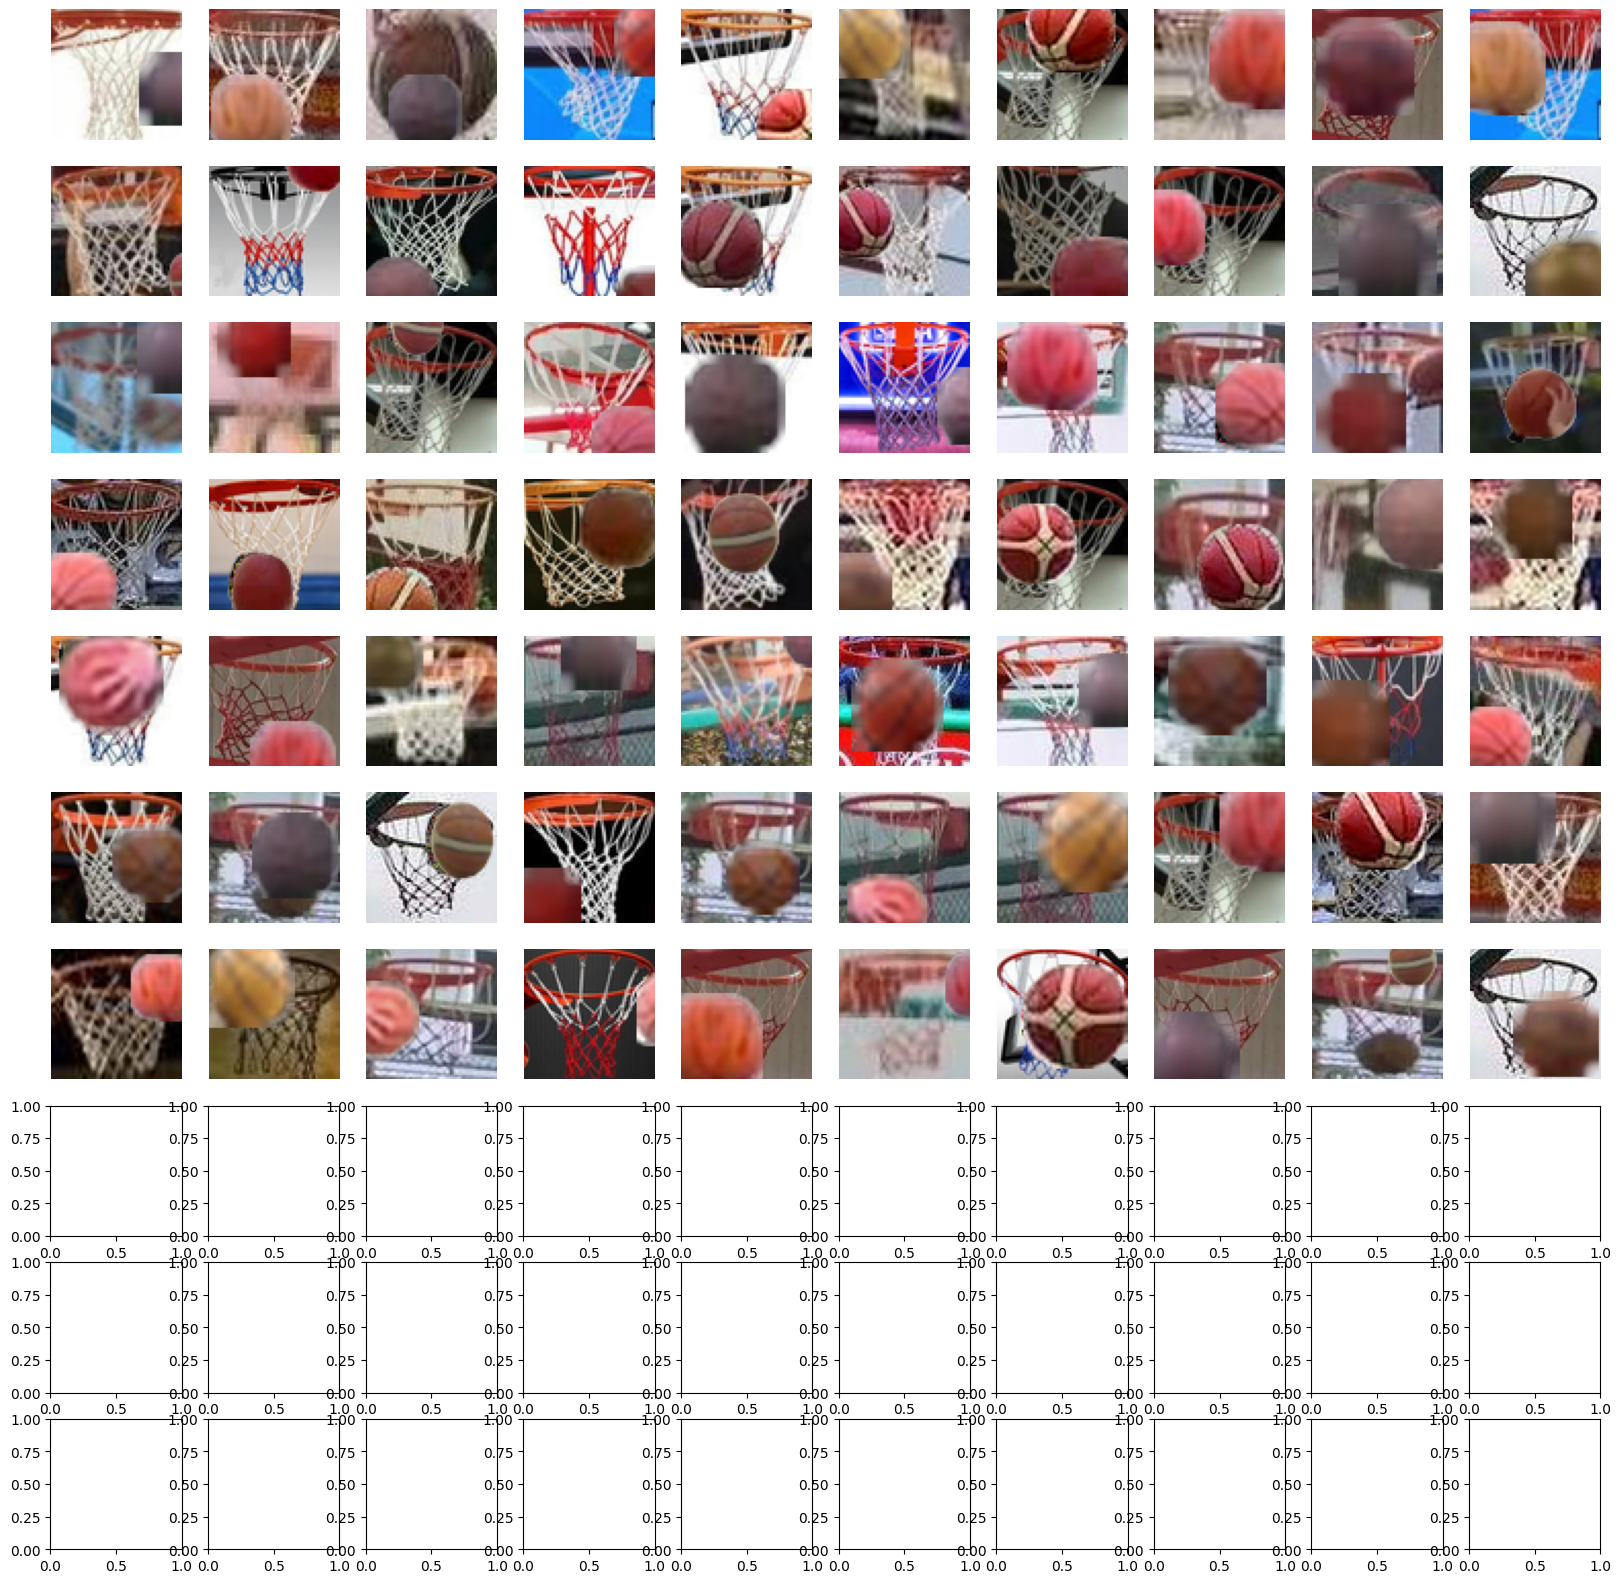

In [9]:

fig, ax = plt.subplots(10, 10, figsize=(20, 20))
ax = ax.flatten()


for i in range(len(random_hoops)):
    ball_path = "isolated_balls/" + np.random.choice(ball_paths)
    hoop_path = "cls_training_data_by_vid/0/" + random_hoops[i]

    # Load and resize hoop image
    hoop_image = Image.open(hoop_path).convert("RGBA")
    hoop_image = hoop_image.resize((64, 64), Image.Resampling.LANCZOS)

    # Load and resize ball image
    ball_image = Image.open(ball_path).convert("RGBA")
    ball_image = ball_image.resize((64, 64), Image.Resampling.LANCZOS)

    # Separate alpha channel from ball image
    ball_rgb = ball_image.convert("RGB")
    ball_alpha = ball_image.split()[-1]

    # Apply transformations to RGB part of ball image
    transformed_ball_rgb = train_transforms(ball_rgb)

    # Convert the transformed RGB tensor back to PIL Image for each channel
    transformed_r = TF.to_pil_image(transformed_ball_rgb[0].unsqueeze(0))
    transformed_g = TF.to_pil_image(transformed_ball_rgb[1].unsqueeze(0))
    transformed_b = TF.to_pil_image(transformed_ball_rgb[2].unsqueeze(0))

    # Combine the transformed RGB images with the alpha channel
    transformed_ball_image = Image.merge("RGBA", (transformed_r, transformed_g, transformed_b, ball_alpha))

    # Resize transformed ball image
    ratio = np.random.uniform(0.5, 0.8)
    new_ball_image = transformed_ball_image.resize((round(hoop_image.width * ratio), round(hoop_image.height * ratio)), Image.Resampling.LANCZOS)

    # Create composite image
    composite_image = Image.new("RGBA", hoop_image.size)
    composite_image.paste(hoop_image, (0, 0), hoop_image)

    # Calculate ball position
    ball_position = ((hoop_image.width - new_ball_image.width) // 2, (hoop_image.height - new_ball_image.height) // 3)
    max_x = hoop_image.width - new_ball_image.width
    max_y = hoop_image.height - new_ball_image.height
    random_x = np.random.randint(-max_x//1.5, max_x * 2)
    random_y = np.random.randint(-max_y // 1.5, max_y * 2)
    ball_position = (random_x, random_y)
    # Paste ball image onto composite image
    composite_image.paste(new_ball_image, ball_position, new_ball_image)
    composite_image_rgb = composite_image.convert("RGB")

    save_path = os.path.join(save_dir, f'composite_image_{i}.jpg')
    composite_image_rgb.save(save_path)

    # Display the composite image
    ax[i].imshow(composite_image)
    ax[i].axis('off')



In [12]:
# move all the synthetic images to the training data folder
synthetic_image_paths = os.listdir(save_dir)
for image_path in synthetic_image_paths:
    shutil.move(os.path.join(save_dir, image_path), "cls_training_data_by_vid/0")

In [39]:
hoop_image.size

(34, 33)

In [27]:
import os
import random
from PIL import Image, ImageOps
from PIL import ImageEnhance

def random_rotation(image):
    return image.rotate(random.randint(-30, 30))

def horizontal_flip(image):
    return ImageOps.mirror(image)

def add_noise(image):
    noise_factor = random.uniform(0.01, 0.05)
    noise = Image.effect_noise(image.size, noise_factor)
    return Image.blend(image, noise, random.uniform(0.1, 0.2))

def augment_image(image_path, output_dir, augmentation_functions):
    img = Image.open(image_path)
    for i, augment in enumerate(augmentation_functions):
        augmented_img = augment(img)
        augmented_img_path = os.path.join(output_dir, f"{os.path.basename(image_path).split('.')[0]}_aug{i}.jpg")
        augmented_img.save(augmented_img_path)
        
def adjust_brightness(image):
    enhancer = ImageEnhance.Brightness(image)
    return enhancer.enhance(random.uniform(0.5, 1.5))

def adjust_contrast(image):
    enhancer = ImageEnhance.Contrast(image)
    return enhancer.enhance(random.uniform(0.5, 1.5))

def adjust_saturation(image):
    enhancer = ImageEnhance.Color(image)
    return enhancer.enhance(random.uniform(0.5, 1.5))

# Modify the augment_image function to include color adjustments
def augment_image(image_path, output_dir, augmentation_functions):
    img = Image.open(image_path)
    augmented_img = img.copy()
    for augment in augmentation_functions:
        augmented_img = augment(augmented_img)
    
    augmented_img_path = os.path.join(output_dir, f"{os.path.basename(image_path).split('.')[0]}_aug.jpg")
    augmented_img.save(augmented_img_path)

# Directories
class_1_dir = 'cls_training_data_by_vid/1'  # Update with the path to your class 1 images
augmented_class_1_dir = 'cls_training_data_by_vid/augmented_class_1'  # Update with your desired output path
os.makedirs(augmented_class_1_dir, exist_ok=True)

augmentations = [random_rotation, horizontal_flip, adjust_brightness, adjust_contrast, adjust_saturation]

percentage_to_augment = 1  # for example, augment 50% of the images
selected_files = random.sample(os.listdir(class_1_dir), int(len(os.listdir(class_1_dir)) * percentage_to_augment))

for image_file in selected_files:
    if '.DS_Store' in image_file or '_aug' in image_file:
        continue
    image_path = os.path.join(class_1_dir, image_file)
    augment_image(image_path, augmented_class_1_dir, augmentations)



In [28]:
# move all the augmented images to the training data folder and remove the folder
augmented_image_paths = os.listdir(augmented_class_1_dir)
for image_path in augmented_image_paths:
    shutil.copy(os.path.join(augmented_class_1_dir, image_path), "cls_training_data_by_vid/1")
shutil.rmtree(augmented_class_1_dir)

In [21]:
len(os.listdir("cls_training_data_by_vid/0"))

1471